In [2]:
import scanpy as sc
import tifffile

In [3]:
import squidpy as sq
import numpy as np
import matplotlib.pyplot as plt

#### Visium ffpe spatial transcriptomics breast cancer

In [4]:
adata = sc.read_visium('./data/Visium_FFPE_Human_Breast_Cancer')
adata.var_names_make_unique()
adata

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


AnnData object with n_obs × n_vars = 2518 × 17943
    obs: 'in_tissue', 'array_row', 'array_col'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial'
    obsm: 'spatial'

/diskmnt/Projects/Users/estorrs/miniconda3/envs/stardist/lib/python3.7/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'feature_types' as categorical
/diskmnt/Projects/Users/estorrs/miniconda3/envs/stardist/lib/python3.7/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'genome' as categorical


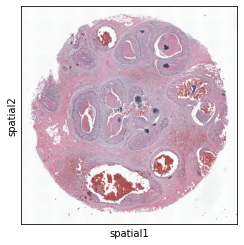

In [5]:
sc.pl.spatial(adata)

In [6]:
len(set(adata.var.index))

17943

###### segment cell nuclei

In [7]:
from stardist.models import StarDist2D
from csbdeep.utils import normalize

2022-04-20 13:21:21.776396: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/lib:/usr/lib64:/usr/local/lib:/usr/lib64:
2022-04-20 13:21:21.776431: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [8]:
hires_he_img = tifffile.imread(
    './data/Visium_FFPE_Human_Breast_Cancer/Visium_FFPE_Human_Breast_Cancer_image.tif')
hires_he_img.shape

(25233, 27452, 3)

In [9]:
img = sq.im.ImageContainer(hires_he_img, layer="image")

In [10]:
def stardist_2D_versatile_he(img, nms_thresh=None, prob_thresh=None):
    #axis_norm = (0,1)   # normalize channels independently
    axis_norm = (0,1,2) # normalize channels jointly
    # Make sure to normalize the input image beforehand or supply a normalizer to the prediction function.
    # this is the default normalizer noted in StarDist examples.
    img = normalize(img, 1, 99.8, axis=axis_norm)
    model = StarDist2D.from_pretrained('2D_versatile_he')
    labels, _ = model.predict_instances(img, nms_thresh=nms_thresh, prob_thresh=prob_thresh)
    return labels

In [11]:
StarDist2D.from_pretrained('2D_versatile_he')

Found model '2D_versatile_he' for 'StarDist2D'.


2022-04-20 13:21:26.714534: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-04-20 13:21:26.715063: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/lib:/usr/lib64:/usr/local/lib:/usr/lib64:
2022-04-20 13:21:26.715100: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2022-04-20 13:21:26.715169: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (sitka): /proc/driver/nvidia/version does not exist
2022-04-20 13:21:26.715625: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512

Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


StarDist2D(2D_versatile_he): YXC → YXC
├─ Directory: None
└─ Config2D(axes='YXC', backbone='unet', grid=(2, 2), n_channel_in=3, n_channel_out=33, n_dim=2, n_rays=32, net_conv_after_unet=128, net_input_shape=[None, None, 3], net_mask_shape=[None, None, 1], train_background_reg=0.0001, train_batch_size=8, train_checkpoint='weights_best.h5', train_checkpoint_epoch='weights_now.h5', train_checkpoint_last='weights_last.h5', train_completion_crop=32, train_dist_loss='mae', train_epochs=200, train_foreground_only=0.9, train_learning_rate=0.0003, train_loss_weights=[1, 0.1], train_n_val_patches=3, train_patch_size=[512, 512], train_reduce_lr={'factor': 0.5, 'patience': 50, 'min_delta': 0}, train_shape_completion=False, train_steps_per_epoch=200, train_tensorboard=True, unet_activation='relu', unet_batch_norm=False, unet_dropout=0.0, unet_kernel_size=[3, 3], unet_last_activation='relu', unet_n_conv_per_depth=2, unet_n_depth=3, unet_n_filter_base=32, unet_pool=[2, 2], unet_prefix='', use_gpu=Fal

In [22]:
def stardist_2D_versatile_he(img, nms_thresh=None, prob_thresh=None):
    #axis_norm = (0,1)   # normalize channels independently
    axis_norm = (0,1,2) # normalize channels jointly
    # Make sure to normalize the input image beforehand or supply a normalizer to the prediction function.
    # this is the default normalizer noted in StarDist examples.
    img = normalize(img, 1, 99.8, axis=axis_norm)
    model = StarDist2D.from_pretrained('2D_versatile_he')
    labels, _ = model.predict_instances(img, n_tiles=(10, 10, 1), nms_thresh=nms_thresh, prob_thresh=prob_thresh)
    return labels

In [18]:
model = StarDist2D.from_pretrained('2D_versatile_he')

Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


In [23]:
%%time
sq.im.segment(
    img=img,
    layer="image",
    channel=None,
    method=stardist_2D_versatile_he,
    layer_added='segmented_stardist_default',
    prob_thresh=.3,
    nms_thresh=None
)

Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [06:01<00:00,  3.61s/it]


CPU times: user 2h 16min 35s, sys: 37min 52s, total: 2h 54min 28s
Wall time: 14min 37s


In [34]:
x = np.asarray(img['segmented_stardist_default'].as_numpy().squeeze())

In [37]:
adata.uns['labeled_nuclei'] = x

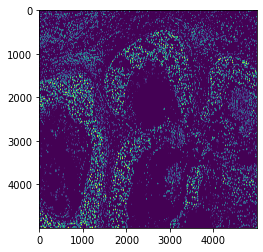

In [36]:
plt.imshow(x[10000:15000, 10000:15000])

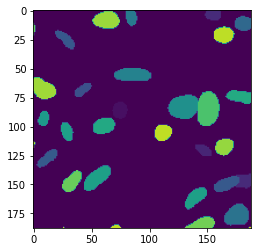

In [49]:
plt.imshow(x[10000:10188, 10000:10188])

calculate number of cells per spot

In [53]:
d = int(adata.uns['spatial']['Visium_FFPE_Human_Breast_Cancer']['scalefactors']['spot_diameter_fullres'])
d

188

In [47]:
adata.obsm['spatial'] # col, row

array([[19934, 16265],
       [ 7893, 18526],
       [18782,  7178],
       ...,
       [11229, 18277],
       [ 9488, 18780],
       [ 9056, 14994]])

In [54]:
def create_circular_mask(h, w, center=None, radius=None):
    # https://stackoverflow.com/questions/44865023/how-can-i-create-a-circular-mask-for-a-numpy-array
    if center is None: # use the middle of the image
        center = (int(w/2), int(h/2))
    if radius is None: # use the smallest distance between the center and image walls
        radius = min(center[0], center[1], w-center[0], h-center[1])

    Y, X = np.ogrid[:h, :w]
    dist_from_center = np.sqrt((X - center[0])**2 + (Y-center[1])**2)

    mask = dist_from_center <= radius
    return mask

In [65]:
circular_mask = create_circular_mask(d, d, radius=int(d/2))
n_cells, spot_to_cells = [], {}
for i, (col, row) in zip(adata.obs.index, adata.obsm['spatial']):
    r1, r2 = row - int(d / 2), row + int(d / 2)
    c1, c2 = col - int(d / 2), col + int(d / 2)
    region = adata.uns['labeled_nuclei'][r1:r2, c1:c2]
    cell_ids = sorted(np.unique(region[circular_mask]))[:-1]
    n_cells.append(len(cell_ids))
    spot_to_cells[i] = cell_ids

In [66]:
adata.uns['spot_to_cell_ids'] = spot_to_cells
adata.obs['total_cells'] = n_cells

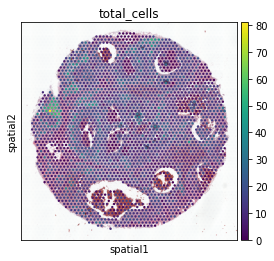

In [68]:
sc.pl.spatial(adata, color='total_cells')

In [146]:
# store cell coordinates instead of mask
from skimage.measure import label, regionprops
props = regionprops(adata.uns['labeled_nuclei'])
coord_map = {}
# p = next(iter(props))
for p in props:
    coord_map[p.label] = [int(p.centroid[0]), int(p.centroid[1])]

adata.uns['cell_id_to_location'] = coord_map

In [148]:
adata.uns.pop('fullres_he')
adata.uns.pop('labeled_nuclei')

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint32)

In [155]:
adata.uns['cell_id_to_location'] = {k:list(v) for k, v in adata.uns['cell_id_to_location'].items()}

In [156]:
adata

AnnData object with n_obs × n_vars = 2518 × 17943
    obs: 'in_tissue', 'array_row', 'array_col', 'total_cells'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial', 'spot_to_cell_ids', 'cell_id_to_location'
    obsm: 'spatial'

In [157]:
adata.write_h5ad('./data/Visium_FFPE_Human_Breast_Cancer/processed.h5ad')

###### 

#### Pollock breast scRNA-seq dataset

In [96]:
adata = sc.read_h5ad('./data/single_cell/brca.h5ad')
adata

AnnData object with n_obs × n_vars = 98564 × 27131
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mito', 'nCount_SCT', 'nFeature_SCT', 'SCT_snn_res.0.5', 'seurat_clusters', 'sample', 'tissue_type', 'cell_type', 'cell_type_specific', 'Piece_ID', 'Clinical_Subtype', 'Bulk_PAM50', 'doublet_score', 'predicted_doublet', 'ident'
    var: 'sct.detection_rate', 'sct.gmean', 'sct.variance', 'sct.residual_mean', 'sct.residual_variance', 'sct.variable'
    obsm: 'X_pca', 'X_umap'
    layers: 'logcounts'

In [97]:
adata.obs

,orig.ident,nCount_RNA,nFeature_RNA,percent.mito,nCount_SCT,nFeature_SCT,SCT_snn_res.0.5,seurat_clusters,sample,tissue_type,cell_type,cell_type_specific,Piece_ID,Clinical_Subtype,Bulk_PAM50,doublet_score,predicted_doublet,ident
_HT062B1_S1PA_AAACCCACACAAATGA-1,TWCE-HT062B1-S1PAA1A1Z1B1,4837.0,1378,0.043829,4154.0,1378,2,2,HT062B1,Tumor tissue,CD8 T cell,NK,HT062B1_S1PA,TNBC,Her2,0.036018,0,2
_HT062B1_S1PA_AAACCCAGTGCTCCGA-1,TWCE-HT062B1-S1PAA1A1Z1B1,6400.0,2369,0.061562,4515.0,2344,4,4,HT062B1,Tumor tissue,Endothelial,Endothelial,HT062B1_S1PA,TNBC,Her2,0.105210,0,4
_HT062B1_S1PA_AAACCCATCGGAATTC-1,TWCE-HT062B1-S1PAA1A1Z1B1,10255.0,2945,0.042321,4558.0,1978,10,10,HT062B1,Tumor tissue,Fibroblast,mCAFs,HT062B1_S1PA,TNBC,Her2,0.051376,0,10
_HT062B1_S1PA_AAACGAACAGCTAACT-1,TWCE-HT062B1-S1PAA1A1Z1B1,1433.0,751,0.073273,3072.0,801,13,13,HT062B1,Tumor tissue,Malignant,Tumor,HT062B1_S1PA,TNBC,Her2,0.013000,0,13
_HT062B1_S1PA_AAACGAAGTAGGGAGG-1,TWCE-HT062B1-S1PAA1A1Z1B1,2256.0,934,0.050089,3281.0,934,2,2,HT062B1,Tumor tissue,CD8 T cell,CD8_T,HT062B1_S1PA,TNBC,Her2,0.027729,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
_HT171B1_BC2_TTTGTTGCACCAGACC-1,TWCE-HT171B1-BC2,4717.0,1660,0.063600,4178.0,1660,8,8,HT171B1,Tumor tissue,CD8 T cell,CD4_T_exhausted,HT171B1_S1H8,TNBC,Basal,0.104260,0,8
_HT171B1_BC2_TTTGTTGCACGTACTA-1,TWCE-HT171B1-BC2,4627.0,1441,0.014048,4117.0,1441,1,1,HT171B1,Tumor tissue,Malignant,Tumor,HT171B1_S1H8,TNBC,Basal,0.034114,0,1
_HT171B1_BC2_TTTGTTGTCCCAAGCG-1,TWCE-HT171B1-BC2,3236.0,1392,0.051916,3482.0,1392,8,8,HT171B1,Tumor tissue,CD8 T cell,CD8_T_exhausted,HT171B1_S1H8,TNBC,Basal,0.027347,0,8
_HT171B1_BC2_TTTGTTGTCCTCACCA-1,TWCE-HT171B1-BC2,13163.0,4124,0.036162,3946.0,1808,7,7,HT171B1,Tumor tissue,Macrophage,Monocyte,HT171B1_S1H8,TNBC,Basal,0.233279,0,7


In [98]:
sample_map = {s:f'sample_{i}' for i, s in enumerate(set(adata.obs['orig.ident']))}
sample_map

{'TWCE-HT088B1-Bc3': 'sample_0',
 'TWCE-HT105B1-XB2': 'sample_1',
 'TWCE-HT067B1-S1H5A2A1Z1B1': 'sample_2',
 'TWCE-HT067B1-S1H2A2A1Z1B1': 'sample_3',
 'TWCE-HT062B1-S1PAA1A1Z1B1': 'sample_4',
 'TWCE-HT171B1-BC1': 'sample_5',
 'TWCE-HT062B1-S1PBA1A1Z1B1': 'sample_6',
 'TWCE-HT077B1-XB2': 'sample_7',
 'TWCE-HT110B1-XB1': 'sample_8',
 'TWCE-HT163B1-BC1': 'sample_9',
 'TWCE-HT154B1-Bc3': 'sample_10',
 'TWCE-HT068B1-S1H2A2A1Z1B1': 'sample_11',
 'TWCE-HT105B1-XB1': 'sample_12',
 'TWCE-HT084B1-XB1': 'sample_13',
 'TWCE-HT103B1-XB2': 'sample_14',
 'TWCE-HT110B1-XB2': 'sample_15',
 'TWCE-HT154B1-Bc2': 'sample_16',
 'TWCE-HT154B1-Bc1': 'sample_17',
 'TWCE-HT062B1-S1R1A1Z1B1': 'sample_18',
 'TWCE-HT065B1-S1H7A2A1Z1B1': 'sample_19',
 'TWCE-HT171B1-BC2': 'sample_20',
 'TWCE-HT103B1-XB1': 'sample_21',
 'TWCE-HT110B1-XB3': 'sample_22',
 'TWCE-HT077B1-XB3': 'sample_23',
 'TWCE-HT065B1-S1H1A2A1Z1B1': 'sample_24',
 'TWCE-HT068B1-S1H1A2A1Z1B1': 'sample_25',
 'TWCE-HT105B1-XB3': 'sample_26',
 'TWCE-HT088B

In [99]:
adata.obs['sample_id'] = [sample_map[x] for x in adata.obs['orig.ident']]
adata.obs

,orig.ident,nCount_RNA,nFeature_RNA,percent.mito,nCount_SCT,nFeature_SCT,SCT_snn_res.0.5,seurat_clusters,sample,tissue_type,cell_type,cell_type_specific,Piece_ID,Clinical_Subtype,Bulk_PAM50,doublet_score,predicted_doublet,ident,sample_id
_HT062B1_S1PA_AAACCCACACAAATGA-1,TWCE-HT062B1-S1PAA1A1Z1B1,4837.0,1378,0.043829,4154.0,1378,2,2,HT062B1,Tumor tissue,CD8 T cell,NK,HT062B1_S1PA,TNBC,Her2,0.036018,0,2,sample_4
_HT062B1_S1PA_AAACCCAGTGCTCCGA-1,TWCE-HT062B1-S1PAA1A1Z1B1,6400.0,2369,0.061562,4515.0,2344,4,4,HT062B1,Tumor tissue,Endothelial,Endothelial,HT062B1_S1PA,TNBC,Her2,0.105210,0,4,sample_4
_HT062B1_S1PA_AAACCCATCGGAATTC-1,TWCE-HT062B1-S1PAA1A1Z1B1,10255.0,2945,0.042321,4558.0,1978,10,10,HT062B1,Tumor tissue,Fibroblast,mCAFs,HT062B1_S1PA,TNBC,Her2,0.051376,0,10,sample_4
_HT062B1_S1PA_AAACGAACAGCTAACT-1,TWCE-HT062B1-S1PAA1A1Z1B1,1433.0,751,0.073273,3072.0,801,13,13,HT062B1,Tumor tissue,Malignant,Tumor,HT062B1_S1PA,TNBC,Her2,0.013000,0,13,sample_4
_HT062B1_S1PA_AAACGAAGTAGGGAGG-1,TWCE-HT062B1-S1PAA1A1Z1B1,2256.0,934,0.050089,3281.0,934,2,2,HT062B1,Tumor tissue,CD8 T cell,CD8_T,HT062B1_S1PA,TNBC,Her2,0.027729,0,2,sample_4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
_HT171B1_BC2_TTTGTTGCACCAGACC-1,TWCE-HT171B1-BC2,4717.0,1660,0.063600,4178.0,1660,8,8,HT171B1,Tumor tissue,CD8 T cell,CD4_T_exhausted,HT171B1_S1H8,TNBC,Basal,0.104260,0,8,sample_20
_HT171B1_BC2_TTTGTTGCACGTACTA-1,TWCE-HT171B1-BC2,4627.0,1441,0.014048,4117.0,1441,1,1,HT171B1,Tumor tissue,Malignant,Tumor,HT171B1_S1H8,TNBC,Basal,0.034114,0,1,sample_20
_HT171B1_BC2_TTTGTTGTCCCAAGCG-1,TWCE-HT171B1-BC2,3236.0,1392,0.051916,3482.0,1392,8,8,HT171B1,Tumor tissue,CD8 T cell,CD8_T_exhausted,HT171B1_S1H8,TNBC,Basal,0.027347,0,8,sample_20
_HT171B1_BC2_TTTGTTGTCCTCACCA-1,TWCE-HT171B1-BC2,13163.0,4124,0.036162,3946.0,1808,7,7,HT171B1,Tumor tissue,Macrophage,Monocyte,HT171B1_S1H8,TNBC,Basal,0.233279,0,7,sample_20


In [100]:
adata.obs.index = [s + '_' + b.split('_')[-1] for b, s in zip(adata.obs.index, adata.obs['sample_id'])]

In [101]:
adata.obs

,orig.ident,nCount_RNA,nFeature_RNA,percent.mito,nCount_SCT,nFeature_SCT,SCT_snn_res.0.5,seurat_clusters,sample,tissue_type,cell_type,cell_type_specific,Piece_ID,Clinical_Subtype,Bulk_PAM50,doublet_score,predicted_doublet,ident,sample_id
sample_4_AAACCCACACAAATGA-1,TWCE-HT062B1-S1PAA1A1Z1B1,4837.0,1378,0.043829,4154.0,1378,2,2,HT062B1,Tumor tissue,CD8 T cell,NK,HT062B1_S1PA,TNBC,Her2,0.036018,0,2,sample_4
sample_4_AAACCCAGTGCTCCGA-1,TWCE-HT062B1-S1PAA1A1Z1B1,6400.0,2369,0.061562,4515.0,2344,4,4,HT062B1,Tumor tissue,Endothelial,Endothelial,HT062B1_S1PA,TNBC,Her2,0.105210,0,4,sample_4
sample_4_AAACCCATCGGAATTC-1,TWCE-HT062B1-S1PAA1A1Z1B1,10255.0,2945,0.042321,4558.0,1978,10,10,HT062B1,Tumor tissue,Fibroblast,mCAFs,HT062B1_S1PA,TNBC,Her2,0.051376,0,10,sample_4
sample_4_AAACGAACAGCTAACT-1,TWCE-HT062B1-S1PAA1A1Z1B1,1433.0,751,0.073273,3072.0,801,13,13,HT062B1,Tumor tissue,Malignant,Tumor,HT062B1_S1PA,TNBC,Her2,0.013000,0,13,sample_4
sample_4_AAACGAAGTAGGGAGG-1,TWCE-HT062B1-S1PAA1A1Z1B1,2256.0,934,0.050089,3281.0,934,2,2,HT062B1,Tumor tissue,CD8 T cell,CD8_T,HT062B1_S1PA,TNBC,Her2,0.027729,0,2,sample_4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
sample_20_TTTGTTGCACCAGACC-1,TWCE-HT171B1-BC2,4717.0,1660,0.063600,4178.0,1660,8,8,HT171B1,Tumor tissue,CD8 T cell,CD4_T_exhausted,HT171B1_S1H8,TNBC,Basal,0.104260,0,8,sample_20
sample_20_TTTGTTGCACGTACTA-1,TWCE-HT171B1-BC2,4627.0,1441,0.014048,4117.0,1441,1,1,HT171B1,Tumor tissue,Malignant,Tumor,HT171B1_S1H8,TNBC,Basal,0.034114,0,1,sample_20
sample_20_TTTGTTGTCCCAAGCG-1,TWCE-HT171B1-BC2,3236.0,1392,0.051916,3482.0,1392,8,8,HT171B1,Tumor tissue,CD8 T cell,CD8_T_exhausted,HT171B1_S1H8,TNBC,Basal,0.027347,0,8,sample_20
sample_20_TTTGTTGTCCTCACCA-1,TWCE-HT171B1-BC2,13163.0,4124,0.036162,3946.0,1808,7,7,HT171B1,Tumor tissue,Macrophage,Monocyte,HT171B1_S1H8,TNBC,Basal,0.233279,0,7,sample_20


In [102]:
keep = ['sample_id', 'cell_type', 'cell_type_specific']
adata.obs = adata.obs[keep]
adata.obs

,sample_id,cell_type,cell_type_specific
sample_4_AAACCCACACAAATGA-1,sample_4,CD8 T cell,NK
sample_4_AAACCCAGTGCTCCGA-1,sample_4,Endothelial,Endothelial
sample_4_AAACCCATCGGAATTC-1,sample_4,Fibroblast,mCAFs
sample_4_AAACGAACAGCTAACT-1,sample_4,Malignant,Tumor
sample_4_AAACGAAGTAGGGAGG-1,sample_4,CD8 T cell,CD8_T
...,...,...,...
sample_20_TTTGTTGCACCAGACC-1,sample_20,CD8 T cell,CD4_T_exhausted
sample_20_TTTGTTGCACGTACTA-1,sample_20,Malignant,Tumor
sample_20_TTTGTTGTCCCAAGCG-1,sample_20,CD8 T cell,CD8_T_exhausted
sample_20_TTTGTTGTCCTCACCA-1,sample_20,Macrophage,Monocyte


In [103]:
adata.var

,sct.detection_rate,sct.gmean,sct.variance,sct.residual_mean,sct.residual_variance,sct.variable
AL627309.1,0.002252,0.001591,0.002460,-0.004480,0.719166,0
AL627309.3,0.000243,0.000169,0.000243,0.001617,0.782312,0
AL627309.4,0.000599,0.000415,0.000598,-0.002005,0.667059,0
AL732372.1,0.000101,0.000074,0.000132,0.001163,1.099354,0
AL669831.2,0.000243,0.000169,0.000243,0.002149,0.943548,0
...,...,...,...,...,...,...
AL354822.1,0.016284,0.011908,0.020901,-0.013636,0.780534,0
AC004556.1,0.018912,0.014473,0.030701,-0.004951,0.913103,0
AC233755.2,0.000690,0.000701,0.029216,0.020331,5.924968,1
AC233755.1,0.001349,0.001425,0.023455,0.015212,4.116755,1


In [104]:
adata.var = adata.var[[]]
adata.var

""
AL627309.1
AL627309.3
AL627309.4
AL732372.1
AL669831.2
...
AL354822.1
AC004556.1
AC233755.2
AC233755.1


In [105]:
adata

AnnData object with n_obs × n_vars = 98564 × 27131
    obs: 'sample_id', 'cell_type', 'cell_type_specific'
    obsm: 'X_pca', 'X_umap'
    layers: 'logcounts'

In [106]:
adata.layers.pop('logcounts')

<98564x27131 sparse matrix of type '<class 'numpy.float64'>'
	with 135573895 stored elements in Compressed Sparse Row format>

In [107]:
adata

AnnData object with n_obs × n_vars = 98564 × 27131
    obs: 'sample_id', 'cell_type', 'cell_type_specific'
    obsm: 'X_pca', 'X_umap'

anndata.py (1228): The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
anndata.py (1241): 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
... storing 'sample_id' as categorical


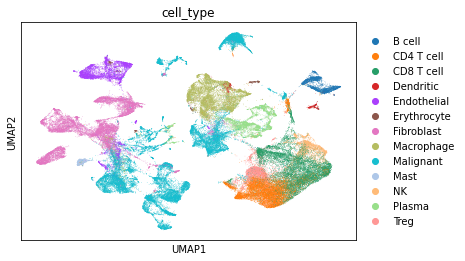

In [108]:
sc.pl.umap(adata, color='cell_type')

In [109]:
from collections import Counter
Counter(adata.obs['cell_type']).most_common()

[('Malignant', 27884),
 ('Fibroblast', 14769),
 ('CD8 T cell', 11649),
 ('CD4 T cell', 11184),
 ('Macrophage', 9824),
 ('Endothelial', 6188),
 ('Plasma', 4879),
 ('Treg', 4404),
 ('B cell', 2972),
 ('NK', 2958),
 ('Mast', 746),
 ('Dendritic', 592),
 ('Erythrocyte', 515)]

In [110]:
from collections import Counter
Counter(adata.obs['cell_type_specific']).most_common()

[('Tumor', 27884),
 ('CD4_T', 11609),
 ('mCAFs', 10156),
 ('Endothelial', 6188),
 ('CD8_T', 6152),
 ('Monocyte', 5747),
 ('NK', 5029),
 ('Plasma', 4879),
 ('vCAFs', 4068),
 ('B', 2972),
 ('Treg', 2681),
 ('CD8_T_exhausted', 2366),
 ('cDC2', 2085),
 ('Macrophage', 1919),
 ('CD4_T_exhausted', 1450),
 ('CD8_T_proliferating', 908),
 ('Mast', 758),
 ('Erythrocyte', 515),
 ('dCAFs', 448),
 ('pDC', 385),
 ('cDC1', 268),
 ('cCAFs', 97)]

In [111]:
adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

ipykernel_launcher.py (1): 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
frame.py (3641): 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [112]:
raw_counts = adata.X.copy()

In [113]:
sc.pp.normalize_total(adata, target_sum=1e4)

In [114]:
sc.pp.log1p(adata)

In [115]:
sc.pp.highly_variable_genes(adata, flavor='seurat')

In [116]:
adata.var

,mt,n_cells_by_counts,mean_counts,pct_dropout_by_counts,total_counts,highly_variable,means,dispersions,dispersions_norm
AL627309.1,False,97,0.001035,99.901587,102.0,False,0.002569,1.073704,-0.495955
AL627309.3,False,9,0.000091,99.990869,9.0,False,0.000236,0.961178,-0.787154
AL627309.4,False,26,0.000264,99.973621,26.0,False,0.000633,0.890559,-0.969902
AL732372.1,False,4,0.000051,99.995942,5.0,False,0.000147,1.527857,0.679314
AL669831.2,False,13,0.000152,99.986811,15.0,False,0.000378,1.249157,-0.041914
...,...,...,...,...,...,...,...,...,...
AL354822.1,False,701,0.007751,99.288787,764.0,False,0.019435,1.171560,-0.242722
AC004556.1,False,1006,0.011353,98.979343,1119.0,False,0.028363,1.224769,-0.105024
AC233755.2,False,60,0.001339,99.939126,132.0,False,0.003347,2.774817,3.906229
AC233755.1,False,87,0.001593,99.911732,157.0,False,0.003702,1.905566,1.656760


In [117]:
np.count_nonzero(adata.var['highly_variable'])

1859

In [118]:
adata.var.sort_values('dispersions_norm')

,mt,n_cells_by_counts,mean_counts,pct_dropout_by_counts,total_counts,highly_variable,means,dispersions,dispersions_norm
IGKV1-37,False,1,0.000010,99.998985,1.0,False,0.000019,0.629422,-1.645681
ODF2-AS1,False,1,0.000010,99.998985,1.0,False,0.000020,0.685774,-1.499850
AC093915.1,False,1,0.000010,99.998985,1.0,False,0.000020,0.694348,-1.477663
GPC6-AS2,False,1,0.000010,99.998985,1.0,False,0.000021,0.708667,-1.440607
AC026355.2,False,1,0.000010,99.998985,1.0,False,0.000021,0.711719,-1.432710
...,...,...,...,...,...,...,...,...,...
IGKV3-11,False,405,0.052240,99.589099,5149.0,True,0.114609,6.287840,12.997320
IGLV3-19,False,416,0.061280,99.577939,6040.0,True,0.119847,6.314810,13.067114
DCD,False,87,0.025029,99.911732,2467.0,True,0.055619,6.441239,13.394291
PGC,False,42,0.028276,99.957388,2787.0,True,0.067495,6.832930,14.407918


In [93]:
adata.obs

,sample_id,cell_type,cell_type_specific,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt
sample_4_AAACCCACACAAATGA-1,sample_4,CD8 T cell,NK,1378,4154.0,171.0,4.116514
sample_4_AAACCCAGTGCTCCGA-1,sample_4,Endothelial,Endothelial,2344,4515.0,245.0,5.426357
sample_4_AAACCCATCGGAATTC-1,sample_4,Fibroblast,mCAFs,1978,4558.0,172.0,3.773585
sample_4_AAACGAACAGCTAACT-1,sample_4,Malignant,Tumor,801,3072.0,251.0,8.170572
sample_4_AAACGAAGTAGGGAGG-1,sample_4,CD8 T cell,CD8_T,934,3281.0,184.0,5.608047
...,...,...,...,...,...,...,...
sample_20_TTTGTTGCACCAGACC-1,sample_20,CD8 T cell,CD4_T_exhausted,1660,4178.0,247.0,5.911920
sample_20_TTTGTTGCACGTACTA-1,sample_20,Malignant,Tumor,1441,4117.0,53.0,1.287345
sample_20_TTTGTTGTCCCAAGCG-1,sample_20,CD8 T cell,CD8_T_exhausted,1392,3482.0,196.0,5.628949
sample_20_TTTGTTGTCCTCACCA-1,sample_20,Macrophage,Monocyte,1808,3946.0,149.0,3.775976


In [119]:
adata.write_h5ad('./data/single_cell/brca_processed.h5ad')

###### sandbox

In [3]:
# Import the StarDist 2D segmentation models.
from stardist.models import StarDist2D
# Import the recommended normalization technique for stardist.
from csbdeep.utils import normalize

2022-04-20 13:01:44.533696: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/lib:/usr/lib64:/usr/local/lib:/usr/lib64:
2022-04-20 13:01:44.533733: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [4]:
StarDist2D.from_pretrained()

There are 4 registered models for 'StarDist2D':

Name                  Alias(es)
────                  ─────────
'2D_versatile_fluo'   'Versatile (fluorescent nuclei)'
'2D_versatile_he'     'Versatile (H&E nuclei)'
'2D_paper_dsb2018'    'DSB 2018 (from StarDist 2D paper)'
'2D_demo'             None


In [5]:
hires_he_img = tifffile.imread(
    './data/Visium_FFPE_Human_Breast_Cancer/Visium_FFPE_Human_Breast_Cancer_image.tif')
hires_he_img.shape

(25233, 27452, 3)

In [6]:
img = sq.im.ImageContainer(hires_he_img, layer="image")

In [27]:
def stardist_2D_versatile_he(img, nms_thresh=None, prob_thresh=None):
    #axis_norm = (0,1)   # normalize channels independently
    axis_norm = (0,1,2) # normalize channels jointly
    # Make sure to normalize the input image beforehand or supply a normalizer to the prediction function.
    # this is the default normalizer noted in StarDist examples.
    img = normalize(img, 1, 99.8, axis=axis_norm)
    model = StarDist2D.from_pretrained('2D_versatile_he')
    labels, _ = model.predict_instances(img, nms_thresh=nms_thresh, prob_thresh=prob_thresh)
    return labels

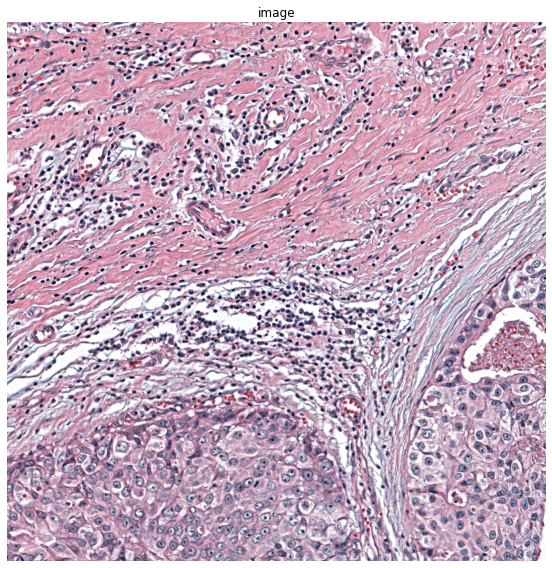

In [31]:
crop = img.crop_corner(10000, 10000, size=2000)
crop.show("image")

In [9]:
StarDist2D.from_pretrained('2D_versatile_he')

Found model '2D_versatile_he' for 'StarDist2D'.
5300224/5294730 [==============================] - 0s 0us/step


2022-04-20 13:03:13.183665: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-04-20 13:03:13.184810: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/lib:/usr/lib64:/usr/local/lib:/usr/lib64:
2022-04-20 13:03:13.184837: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2022-04-20 13:03:13.184880: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (sitka): /proc/driver/nvidia/version does not exist
2022-04-20 13:03:13.185186: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512

Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


StarDist2D(2D_versatile_he): YXC → YXC
├─ Directory: None
└─ Config2D(axes='YXC', backbone='unet', grid=(2, 2), n_channel_in=3, n_channel_out=33, n_dim=2, n_rays=32, net_conv_after_unet=128, net_input_shape=[None, None, 3], net_mask_shape=[None, None, 1], train_background_reg=0.0001, train_batch_size=8, train_checkpoint='weights_best.h5', train_checkpoint_epoch='weights_now.h5', train_checkpoint_last='weights_last.h5', train_completion_crop=32, train_dist_loss='mae', train_epochs=200, train_foreground_only=0.9, train_learning_rate=0.0003, train_loss_weights=[1, 0.1], train_n_val_patches=3, train_patch_size=[512, 512], train_reduce_lr={'factor': 0.5, 'patience': 50, 'min_delta': 0}, train_shape_completion=False, train_steps_per_epoch=200, train_tensorboard=True, unet_activation='relu', unet_batch_norm=False, unet_dropout=0.0, unet_kernel_size=[3, 3], unet_last_activation='relu', unet_n_conv_per_depth=2, unet_n_depth=3, unet_n_filter_base=32, unet_pool=[2, 2], unet_prefix='', use_gpu=Fal

In [32]:
sq.im.segment(
    img=crop,
    layer="image",
    channel=None,
    method=stardist_2D_versatile_he,
    layer_added='segmented_stardist_default',
    prob_thresh=.3,
    nms_thresh=None
)

Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


2022-04-20 13:17:53.788576: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 512000000 exceeds 10% of free system memory.


ImageContainer[shape=(2000, 2000), layers=['image', 'segmented_stardist_default']]
Number of segments in crop: 1695


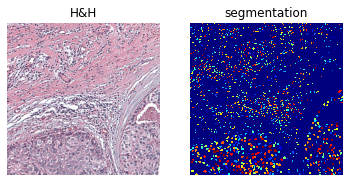

In [11]:
print(crop)
print(f"Number of segments in crop: {len(np.unique(crop['segmented_stardist_default']))}")

fig, axes = plt.subplots(1, 2)
crop.show("image", ax=axes[0])
_ = axes[0].set_title("H&H")
crop.show("segmented_stardist_default", cmap="jet", interpolation="none", ax=axes[1])
_ = axes[1].set_title("segmentation")

ImageContainer[shape=(2000, 2000), layers=['image', 'segmented_stardist_default']]
Number of segments in crop: 2390


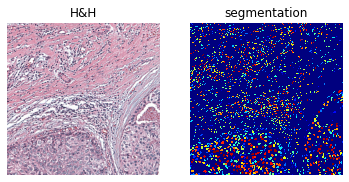

In [33]:
print(crop)
print(f"Number of segments in crop: {len(np.unique(crop['segmented_stardist_default']))}")

fig, axes = plt.subplots(1, 2)
crop.show("image", ax=axes[0])
_ = axes[0].set_title("H&H")
crop.show("segmented_stardist_default", cmap="jet", interpolation="none", ax=axes[1])
_ = axes[1].set_title("segmentation")